# **Installs**

In [ ]:
!pip install pydot --quiet
!pip install gensim --quiet
!pip install tensorflow-datasets --quiet
!pip install -U tensorflow-text --quiet
!pip install transformers --quiet
!pip install numba

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 88.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 86.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 61.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 75.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.5 MB/s eta 0:00:00


## **Imports**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tqdm import tqdm
import pandas as  pd
from transformers import (
    BertTokenizer,
    BertModel,
    TFBertModel,
    BertConfig,
    AutoTokenizer,
    AutoModel,
)

from transformers import AdamW, get_linear_schedule_with_warmup
import numpy as np
from sklearn.metrics import classification_report
from sklearn import metrics
from numba import cuda

In [ ]:
tf.config.run_functions_eagerly(True)

# **Data Load**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
GNE_PATH = '/content/drive/MyDrive/w266_final_project/data/GoodNewsEveryone'
AUGMENT_PATH = '/content/drive/MyDrive/w266_final_project/data/AugmentExperiments'

In [ ]:
gne_train_preprocessed = pd.read_csv(f'{GNE_PATH}/gne_train_preprocessed.csv')
gne_valid_preprocessed = pd.read_csv(f'{GNE_PATH}/gne_valid_preprocessed.csv')
gne_test_preprocessed = pd.read_csv(f'{GNE_PATH}/gne_test_preprocessed.csv')

In [ ]:
cause_model_name = 'mrm8488/spanbert-finetuned-squadv2'

spanbert_tokenizer = BertTokenizer.from_pretrained(cause_model_name)
spanbert_model = TFBertModel.from_pretrained(cause_model_name, output_hidden_states = True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['qa_outputs.bias', 'qa_outputs.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
gne_train_preprocessed.head()

,Unnamed: 0,headline,dominant_emotion,cause,cause_span,start_index,end_index,emotion_label
0,3466,delta airlines refuses to boycott georgia over...,disgust,"[[""to boycott georgia over abortion laws""]]",to boycott georgia over abortion laws,4,11,2
1,1848,french special forces rescue hostages in a dea...,joy,"[[""rescue hostages in a deadly burkina faso ra...",rescue hostages in a deadly burkina faso raid,5,17,5
2,3195,"palestinian government sworn in, again, after ...",negative_surprise,"[[""sworn in, again, after botched oath""]]","sworn in, again, after botched oath",5,14,8
3,3683,cleric: muslims ‘have a duty’ to obtain nuclea...,negative_anticipation_including_pessimism,"[[""to obtain nuclear weapons""]]",to obtain nuclear weapons,14,17,7
4,194,usa today sports attacks on 'raging' trump app...,disgust,"[[""appear to be coordinated media campaign""]]",appear to be coordinated media campaign,12,17,2


In [ ]:
target_names = list(np.unique(gne_train_preprocessed[['emotion_label', 'dominant_emotion']].sort_values(['emotion_label'])['dominant_emotion']))
target_names

['anger',
 'annoyance',
 'disgust',
 'fear',
 'guilt',
 'joy',
 'love_including_like',
 'negative_anticipation_including_pessimism',
 'negative_surprise',
 'positive_anticipation_including_optimism',
 'positive_surprise',
 'pride',
 'sadness',
 'shame',
 'trust']

In [ ]:
MAX_SEQUENCE_LENGTH = 124 # Using 124 for max sequence length in our data.
beam_size = 4 # Beam size for predicting end index given start index for emotion cause spans

In [ ]:
# Our experiments involve AUGMENTING / APPENDING on our TRAINING DATA.
# Define a function to process and tokenize training data for re-use throughout experiments.
def process_train_data(df):

  ec_train_texts = list(df.headline)
  ec_train_e_labels = np.array(df.emotion_label)
  ec_train_si_labels = np.array(df.start_index)
  ec_train_ei_labels = np.array(df.end_index)
  ec_train_encodings = spanbert_tokenizer(ec_train_texts, truncation=True, padding='max_length', max_length=MAX_SEQUENCE_LENGTH, return_tensors='tf')

  return ec_train_texts, ec_train_e_labels, ec_train_si_labels, ec_train_ei_labels, ec_train_encodings

In [ ]:
ec_valid_texts = list(gne_valid_preprocessed.headline)
ec_test_texts = list(gne_test_preprocessed.headline)

ec_valid_e_labels = np.array(gne_valid_preprocessed.emotion_label)
ec_test_e_labels = np.array(gne_test_preprocessed.emotion_label)

ec_valid_si_labels = np.array(gne_valid_preprocessed.start_index)
ec_test_si_labels = np.array(gne_test_preprocessed.start_index)

ec_valid_ei_labels = np.array(gne_valid_preprocessed.end_index)
ec_test_ei_labels = np.array(gne_test_preprocessed.end_index)

In [ ]:
ec_valid_encodings = spanbert_tokenizer(ec_valid_texts, truncation=True, padding='max_length', max_length=MAX_SEQUENCE_LENGTH, return_tensors='tf')
ec_test_encodings = spanbert_tokenizer(ec_test_texts, truncation=True, padding='max_length', max_length=MAX_SEQUENCE_LENGTH, return_tensors='tf')

# **Scratch Work - to design the model**

In [ ]:
# @title
spanbert_out = spanbert_model([ec_valid_encodings.input_ids, ec_valid_encodings.token_type_ids, ec_valid_encodings.attention_mask])

NameError: ignored

In [ ]:
# @title
out = np.array(spanbert_out[2])

In [ ]:
# @title
# FOR EMOTION CLASSIFICATION: AVERAGE out ALL hidden states. The average SHOULD be the SAME size as the attention vector.
o = tf.stack(
    tuple(out[-i - 1] for i in range(12)), axis=1)
print(o.shape)
o

(12, 12, 124, 768)


<tf.Tensor: shape=(12, 12, 124, 768), dtype=float32, numpy=
array([[[[-0.12149484, -0.19294368, -0.1879348 , ..., -0.11795254,
          -0.11509802,  0.19834341],
         [-0.05254162, -0.17423852, -0.19125736, ..., -0.11225103,
          -0.12786518,  0.22386615],
         [-0.05584331, -0.16275132, -0.19315693, ..., -0.10716303,
          -0.12371977,  0.22144574],
         ...,
         [-0.02064001, -0.2057844 , -0.18367349, ..., -0.14269438,
          -0.13874489,  0.23958394],
         [-0.02371099, -0.20563737, -0.1836034 , ..., -0.14366648,
          -0.1374694 ,  0.2381201 ],
         [-0.03111994, -0.20308977, -0.18472582, ..., -0.13800286,
          -0.13609931,  0.2353111 ]],

        [[-0.11788816,  0.02051882, -0.09626473, ...,  0.2125257 ,
           0.29256135, -0.18052377],
         [-0.12209865,  0.22518602, -0.10208389, ...,  0.17795436,
           0.273975  , -0.22681662],
         [-0.13098134,  0.251634  , -0.11215764, ...,  0.19249701,
           0.29300457, -0

In [ ]:
# @title
mn = tf.math.reduce_mean(o, axis = 1)
mn

<tf.Tensor: shape=(12, 124, 768), dtype=float32, numpy=
array([[[-0.11873361,  0.00962868, -0.07081679, ..., -0.0113312 ,
         -0.06088461,  0.15646839],
        [-0.10059383,  0.09212306, -0.1117653 , ...,  0.1148148 ,
         -0.13936608,  0.17987907],
        [-0.2567078 ,  0.19391023, -0.02039279, ...,  0.12328783,
          0.01258335,  0.0447364 ],
        ...,
        [-0.07562445,  0.07250457, -0.09576301, ..., -0.02936693,
         -0.09037619,  0.09831848],
        [-0.08065974,  0.06743708, -0.09433597, ..., -0.02164375,
         -0.07306152,  0.08417946],
        [-0.07180012,  0.06522585, -0.09692509, ..., -0.02991987,
         -0.05663504,  0.10267846]],

       [[-0.1091171 ,  0.0390369 , -0.07514993, ..., -0.0207424 ,
         -0.01502507,  0.12430739],
        [ 0.01028993,  0.10161189, -0.19358397, ...,  0.14858182,
         -0.1139246 ,  0.11041389],
        [-0.08443069,  0.2178551 , -0.16224341, ...,  0.14177339,
          0.06573663,  0.00821751],
        ...

In [ ]:
# @title
mn_cls = mn[:,0,:]

In [ ]:
# @title
tf.keras.layers.Dense(5, activation='softmax', name='e_classification_layer')(mn_cls)

<tf.Tensor: shape=(12, 5), dtype=float32, numpy=
array([[0.24056952, 0.19019958, 0.18393365, 0.19941856, 0.18587875],
       [0.23600127, 0.18836828, 0.18620141, 0.20386747, 0.18556166],
       [0.26492658, 0.20596936, 0.16793911, 0.20268261, 0.15848234],
       [0.19479358, 0.15805496, 0.1957515 , 0.22505644, 0.22634347],
       [0.19342913, 0.16162473, 0.18945077, 0.22502169, 0.2304737 ],
       [0.24447016, 0.1876766 , 0.18198489, 0.19882983, 0.18703856],
       [0.20640226, 0.16431913, 0.1908429 , 0.22044714, 0.21798854],
       [0.27096024, 0.22194721, 0.15969908, 0.20103309, 0.14636038],
       [0.23624656, 0.18582928, 0.18728746, 0.20306848, 0.18756816],
       [0.23618276, 0.19227433, 0.1828981 , 0.20006417, 0.1885807 ],
       [0.22110316, 0.16871497, 0.18811767, 0.21922   , 0.20284428],
       [0.27336016, 0.23606609, 0.15964621, 0.18896781, 0.14195973]],
      dtype=float32)>

In [ ]:
# @title
s = [tf.keras.layers.Dense(1)(tf.keras.layers.Dropout(0.3)(mn))
     for _ in range(5)]
rm = tf.math.reduce_mean(s, axis=0)
sq = tf.squeeze(rm, axis=-1)
sft = tf.keras.layers.Softmax()(sq)
sft

In [ ]:
# @title
# Preprocessing NOTE: Start positions must be IN LINE with BERT tokenization!
start_positions = tf.keras.layers.Input(shape=(1,), dtype=tf.int64)

In [ ]:
# @title
idx = tf.keras.layers.Identity()(np.array([[2], [11]]))
idx

In [ ]:
# @title
mn

In [ ]:
# @title
st = tf.gather(mn, idx, axis = 1, batch_dims = 1)
rpt = tf.repeat(st, repeats = 12, axis = 1)
ct = tf.concat([mn, rpt], axis = -1)
lnct = tf.keras.layers.Dense(768, activation = 'tanh')(ct)
s2 = [tf.keras.layers.Dense(1)(tf.keras.layers.Dropout(0.3)(lnct))
     for _ in range(5)]
rm2 = tf.reduce_mean(s2, axis=0)
sq2 = tf.squeeze(rm2, axis=-1)
sft2 = tf.keras.layers.Softmax()(sq2)
sft2

# **Model Construction**

In [ ]:
# Suppress missing gradients warnings
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

In [ ]:
# Replicate Bhat and Modi's CSE model - TRAINING.
def create_ece_model(max_sequence_length=MAX_SEQUENCE_LENGTH,
                     num_train_layers=12,
                     dropout=0.3,
                     num_classes=15,
                     learning_rate=0.00005,
                     msd_samples=5):

    # Inputs
    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')
    start_positions = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='start_positions_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    # SpanBERT transformer

    if num_train_layers == 0:
        # Freeze all layers of pre-trained BERT model
        spanbert_model.trainable = False

    elif num_train_layers == 12:
        # Train all layers of the BERT model
        spanbert_model.trainable = True

    else:
        # Restrict training to the num_train_layers outer transformer layers
        retrain_layers = []

        for retrain_layer_number in range(num_train_layers):

            layer_code = '_' + str(11 - retrain_layer_number)
            retrain_layers.append(layer_code)

        print('retrain layers: ', retrain_layers)

        for w in spanbert_model.weights:
            if not any([x in w.name for x in retrain_layers]):
                #print('freezing: ', w)
                w._trainable = False

    bert_out = spanbert_model(bert_inputs)

    # ------EMOTION CLASSIFICATION STEP------

    # Mean Pool all hidden states and extract the CLS tokens
    hidden_states = bert_out[2]

    stacked_states = tf.stack(tuple(hidden_states[-i - 1] for i in range(12)), axis=1)

    meanpooled_states = tf.math.reduce_mean(stacked_states, axis = 1)

    meanpooled_cls_tokens = meanpooled_states[:,0,:]

    # Emotion Classification: Linear Classification Layer
    e_classification = tf.keras.layers.Dense(num_classes, activation='softmax', name='e_classification_layer')(meanpooled_cls_tokens)

    # ------CAUSE CLASSIFICATION STEP------

    # We apply a dense layer of output size 1 to the embedding vectors of size 768 for each token. This gives a scalar representation of each token.
    # Multisample dropout applies different dropout masks across copies of the size 768 input layer and then mean pools the results back together.
    start_logits = tf.squeeze(tf.reduce_mean([
                                             tf.keras.layers.Dense(1)(tf.keras.layers.Dropout(dropout)(meanpooled_states))
                                             for _ in range(msd_samples)], axis=0),
                              axis=-1)

    # Extract probabilities of starting index by softmaxing logits calculated from multisample dropout.
    start_probs = tf.keras.layers.Softmax()(start_logits)

    # In training, start positions are GIVEN. We still output the predicted start positions with the multi-sample dropout above and train,
    # but here we use the given start positions to predict the end positions and then train on end position predictions.

    # Grab the embeddings of the token of the start indices. Repeat them for the entire input length.
    embedding_start_indices = tf.gather(meanpooled_states, start_positions, axis = 1, batch_dims = 1)
    repeated_start_embeds = tf.repeat(embedding_start_indices, repeats = max_sequence_length, axis = 1)

    # Concatenate the start embeddings with the mean pooled states.
    concat_embeds = tf.concat([meanpooled_states, repeated_start_embeds], axis = -1)

    # Apply a linear layer with tanh activation back to an output size of 768 - the original BERT embedding dimension.
    linear_layer = tf.keras.layers.Dense(768, activation = 'tanh')(concat_embeds)

    # Apply the same multisample dropout method for the 768-vectors to get end logits.
    end_logits = tf.squeeze(tf.reduce_mean([
                                           tf.keras.layers.Dense(1)(tf.keras.layers.Dropout(dropout)(linear_layer))
                                           for _ in range(msd_samples)], axis=0),
                            axis=-1)

    # Extract probabilities of ending index by softmaxing logits calculated from multisample dropout.
    end_probs = tf.keras.layers.Softmax()(end_logits)

    # Model and compilation.
    ece_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask, start_positions], outputs=[e_classification, start_probs, end_probs])

    ece_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                      # The loss here is the average of two functions: (1) e_classification loss, and (2) the sum of the losses of start_probs and end_probs divided by 2
                      loss=[tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                            tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                            tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)],
                      # We implement this by including the three cross entropy functions and assigning loss weights correspondingly
                      loss_weights=[0.5, 0.25, 0.25],
                      metrics='accuracy')

    return ece_model

In [ ]:
# Function to compute f1 scores for spans.

def compute_f1_score(si_preds, ei_preds, si_actual, ei_actual):
  f1_score = 0

  for i in range(len(ei_actual)):
    pred_si = si_preds[i]
    pred_ei = ei_preds[i]
    actual_si = si_actual[i]
    actual_ei = ei_actual[i]

    if ei_preds >= si_preds:
      pred_span_tokens = list(range(pred_si, pred_ei + 1))
      actual_span_tokens = list(range(actual_si, actual_ei + 1))

      int_length = len(list(set(pred_span_tokens).intersection(actual_span_tokens)))

      if int_length > 0:
        precision = int_length / len(pred_span_tokens)
        recall = int_length / len(actual_span_tokens)

        f1_ind = (2 * precision * recall) / (precision + recall)

        f1_score += f1_ind

  return f1_score / len(ei_actual)

For INFERENCE/EVALUATION, we need to compute emotion classification, start, and end positions the long way using the weights of our model, as in Bhat and Modi, the architecture differs in training vs. testing. In testing, we take the top k predicted start indices, perform the concatenation operation and predict the end indices for each start index. Argmax the joint probabilities to get the final span prediction.

In [ ]:
# Putting evaluation all into one function
def run_valid_evaluation(ece_model):
  # Output predictions for just the emotion class (in probabilities) and start index
  unaugmented_ec_preds = ece_model.predict([ec_valid_encodings.input_ids, ec_valid_encodings.token_type_ids, ec_valid_encodings.attention_mask, ec_valid_si_labels])[:2]

  # Get the prediction labels associated with probabilities and print classification report
  unaugmented_ec_preds_classes = tf.argmax(unaugmented_ec_preds[0], axis=-1)
  print(classification_report(ec_valid_e_labels, unaugmented_ec_preds_classes, target_names = target_names, digits=4))

  # Evaluation step - manual-ish compute of start and end indices, as the method differs from training

  for i in range(beam_size):
    # Grab the top (i + 1)-th start indices and probabilities for evaluation examples
    top_i_s_prob = -np.sort(-unaugmented_ec_preds[1], axis=-1)[:, i]
    top_i_si = np.argsort(-unaugmented_ec_preds[1], axis=-1)[:, i]

    # Pass those indices into predict, and grab the second output (which is end indices)
    unaugmented_ec_pred_ei = ece_model.predict([ec_valid_encodings.input_ids, ec_valid_encodings.token_type_ids, ec_valid_encodings.attention_mask, top_i_si])[2]

    # Grab predicted end index and its probability (just the max and argmax at index 0!)
    top_i_e_prob = -np.sort(-unaugmented_ec_pred_ei, axis=-1)[:, 0]
    top_i_ei = np.argsort(-unaugmented_ec_pred_ei, axis=-1)[:, 0]

    # Multiply the end index probability by the respective probability of the start index to get joint probability
    top_i_joint = np.multiply(top_i_s_prob, top_i_e_prob)

    # Log the joint and start-end pair
    top_i_ind_pair = np.stack((top_i_si, top_i_ei), axis=-1)

    if i == 0:
      beam_i_joint = top_i_joint
      beam_i_ind_pair = top_i_ind_pair
    elif i == 1:
      beam_i_joint = np.stack((beam_i_joint, top_i_joint), axis = 1)
      beam_i_ind_pair = np.stack((beam_i_ind_pair, top_i_ind_pair), axis = 1)
    else:
      beam_i_joint = np.hstack((beam_i_joint, top_i_joint.reshape(len(top_i_joint), 1)))
      beam_i_ind_pair = np.hstack((beam_i_ind_pair, top_i_ind_pair.reshape(top_i_ind_pair.shape[0], 1, 2)))

  # Highest joint probability results in final choice of start and end index for evaluation
  top_joints = np.argsort(-beam_i_joint, axis=-1)[:,0]
  top_joints

  si_eval_preds = []
  ei_eval_preds = []
  for i in range(len(top_joints)):
    si_eval_preds.append(beam_i_ind_pair[i][top_joints[i]][0])
    ei_eval_preds.append(beam_i_ind_pair[i][top_joints[i]][1])

  print('f1_score:', compute_f1_score(si_eval_preds, ei_eval_preds, ec_valid_si_labels, ec_valid_ei_labels))

In [ ]:
# Putting evaluation all into one function
def run_test_evaluation(ece_model):
  # Output predictions for just the emotion class (in probabilities) and start index
  unaugmented_ec_preds = ece_model.predict([ec_test_encodings.input_ids, ec_test_encodings.token_type_ids, ec_test_encodings.attention_mask, ec_test_si_labels])[:2]

  # Get the prediction labels associated with probabilities and print classification report
  unaugmented_ec_preds_classes = tf.argmax(unaugmented_ec_preds[0], axis=-1)
  print(classification_report(ec_test_e_labels, unaugmented_ec_preds_classes, target_names = target_names, digits=4))

  # Evaluation step - manual-ish compute of start and end indices, as the method differs from training

  for i in range(beam_size):
    # Grab the top (i + 1)-th start indices and probabilities for evaluation examples
    top_i_s_prob = -np.sort(-unaugmented_ec_preds[1], axis=-1)[:, i]
    top_i_si = np.argsort(-unaugmented_ec_preds[1], axis=-1)[:, i]

    # Pass those indices into predict, and grab the second output (which is end indices)
    unaugmented_ec_pred_ei = ece_model.predict([ec_test_encodings.input_ids, ec_test_encodings.token_type_ids, ec_test_encodings.attention_mask, top_i_si])[2]

    # Grab predicted end index and its probability (just the max and argmax at index 0!)
    top_i_e_prob = -np.sort(-unaugmented_ec_pred_ei, axis=-1)[:, 0]
    top_i_ei = np.argsort(-unaugmented_ec_pred_ei, axis=-1)[:, 0]

    # Multiply the end index probability by the respective probability of the start index to get joint probability
    top_i_joint = np.multiply(top_i_s_prob, top_i_e_prob)

    # Log the joint and start-end pair
    top_i_ind_pair = np.stack((top_i_si, top_i_ei), axis=-1)

    if i == 0:
      beam_i_joint = top_i_joint
      beam_i_ind_pair = top_i_ind_pair
    elif i == 1:
      beam_i_joint = np.stack((beam_i_joint, top_i_joint), axis = 1)
      beam_i_ind_pair = np.stack((beam_i_ind_pair, top_i_ind_pair), axis = 1)
    else:
      beam_i_joint = np.hstack((beam_i_joint, top_i_joint.reshape(len(top_i_joint), 1)))
      beam_i_ind_pair = np.hstack((beam_i_ind_pair, top_i_ind_pair.reshape(top_i_ind_pair.shape[0], 1, 2)))

  # Highest joint probability results in final choice of start and end index for evaluation
  top_joints = np.argsort(-beam_i_joint, axis=-1)[:,0]
  top_joints

  si_eval_preds = []
  ei_eval_preds = []
  for i in range(len(top_joints)):
    si_eval_preds.append(beam_i_ind_pair[i][top_joints[i]][0])
    ei_eval_preds.append(beam_i_ind_pair[i][top_joints[i]][1])

  print('f1_score:', compute_f1_score(si_eval_preds, ei_eval_preds, ec_test_si_labels, ec_test_ei_labels))

In [ ]:
# Adjusting the other functions to run for any set of sample encodings, to look at individual predictions.
def run_samp_evaluation(ece_model, encodings, si_labels, e_labels):
  # Output predictions for just the emotion class (in probabilities) and start index
  unaugmented_ec_preds = ece_model.predict([encodings.input_ids, encodings.token_type_ids, encodings.attention_mask, si_labels])[:2]

  # Get the prediction labels associated with probabilities and print classification report
  unaugmented_ec_preds_classes = tf.argmax(unaugmented_ec_preds[0], axis=-1)

  # Evaluation step - manual-ish compute of start and end indices, as the method differs from training

  for i in range(beam_size):
    # Grab the top (i + 1)-th start indices and probabilities for evaluation examples
    top_i_s_prob = -np.sort(-unaugmented_ec_preds[1], axis=-1)[:, i]
    top_i_si = np.argsort(-unaugmented_ec_preds[1], axis=-1)[:, i]

    # Pass those indices into predict, and grab the second output (which is end indices)
    unaugmented_ec_pred_ei = ece_model.predict([encodings.input_ids, encodings.token_type_ids, encodings.attention_mask, top_i_si])[2]

    # Grab predicted end index and its probability (just the max and argmax at index 0!)
    top_i_e_prob = -np.sort(-unaugmented_ec_pred_ei, axis=-1)[:, 0]
    top_i_ei = np.argsort(-unaugmented_ec_pred_ei, axis=-1)[:, 0]

    # Multiply the end index probability by the respective probability of the start index to get joint probability
    top_i_joint = np.multiply(top_i_s_prob, top_i_e_prob)

    # Log the joint and start-end pair
    top_i_ind_pair = np.stack((top_i_si, top_i_ei), axis=-1)

    if i == 0:
      beam_i_joint = top_i_joint
      beam_i_ind_pair = top_i_ind_pair
    elif i == 1:
      beam_i_joint = np.stack((beam_i_joint, top_i_joint), axis = 1)
      beam_i_ind_pair = np.stack((beam_i_ind_pair, top_i_ind_pair), axis = 1)
    else:
      beam_i_joint = np.hstack((beam_i_joint, top_i_joint.reshape(len(top_i_joint), 1)))
      beam_i_ind_pair = np.hstack((beam_i_ind_pair, top_i_ind_pair.reshape(top_i_ind_pair.shape[0], 1, 2)))

  # Highest joint probability results in final choice of start and end index for evaluation
  top_joints = np.argsort(-beam_i_joint, axis=-1)[:,0]
  top_joints

  si_eval_preds = []
  ei_eval_preds = []
  for i in range(len(top_joints)):
    si_eval_preds.append(beam_i_ind_pair[i][top_joints[i]][0])
    ei_eval_preds.append(beam_i_ind_pair[i][top_joints[i]][1])

  return unaugmented_ec_preds_classes, si_eval_preds, ei_eval_preds

## **Model Summary**

In [ ]:
ece_model = create_ece_model()

In [ ]:
ece_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 124)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 124)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 124)]                0         []                            
 tLayer)                                                                                      

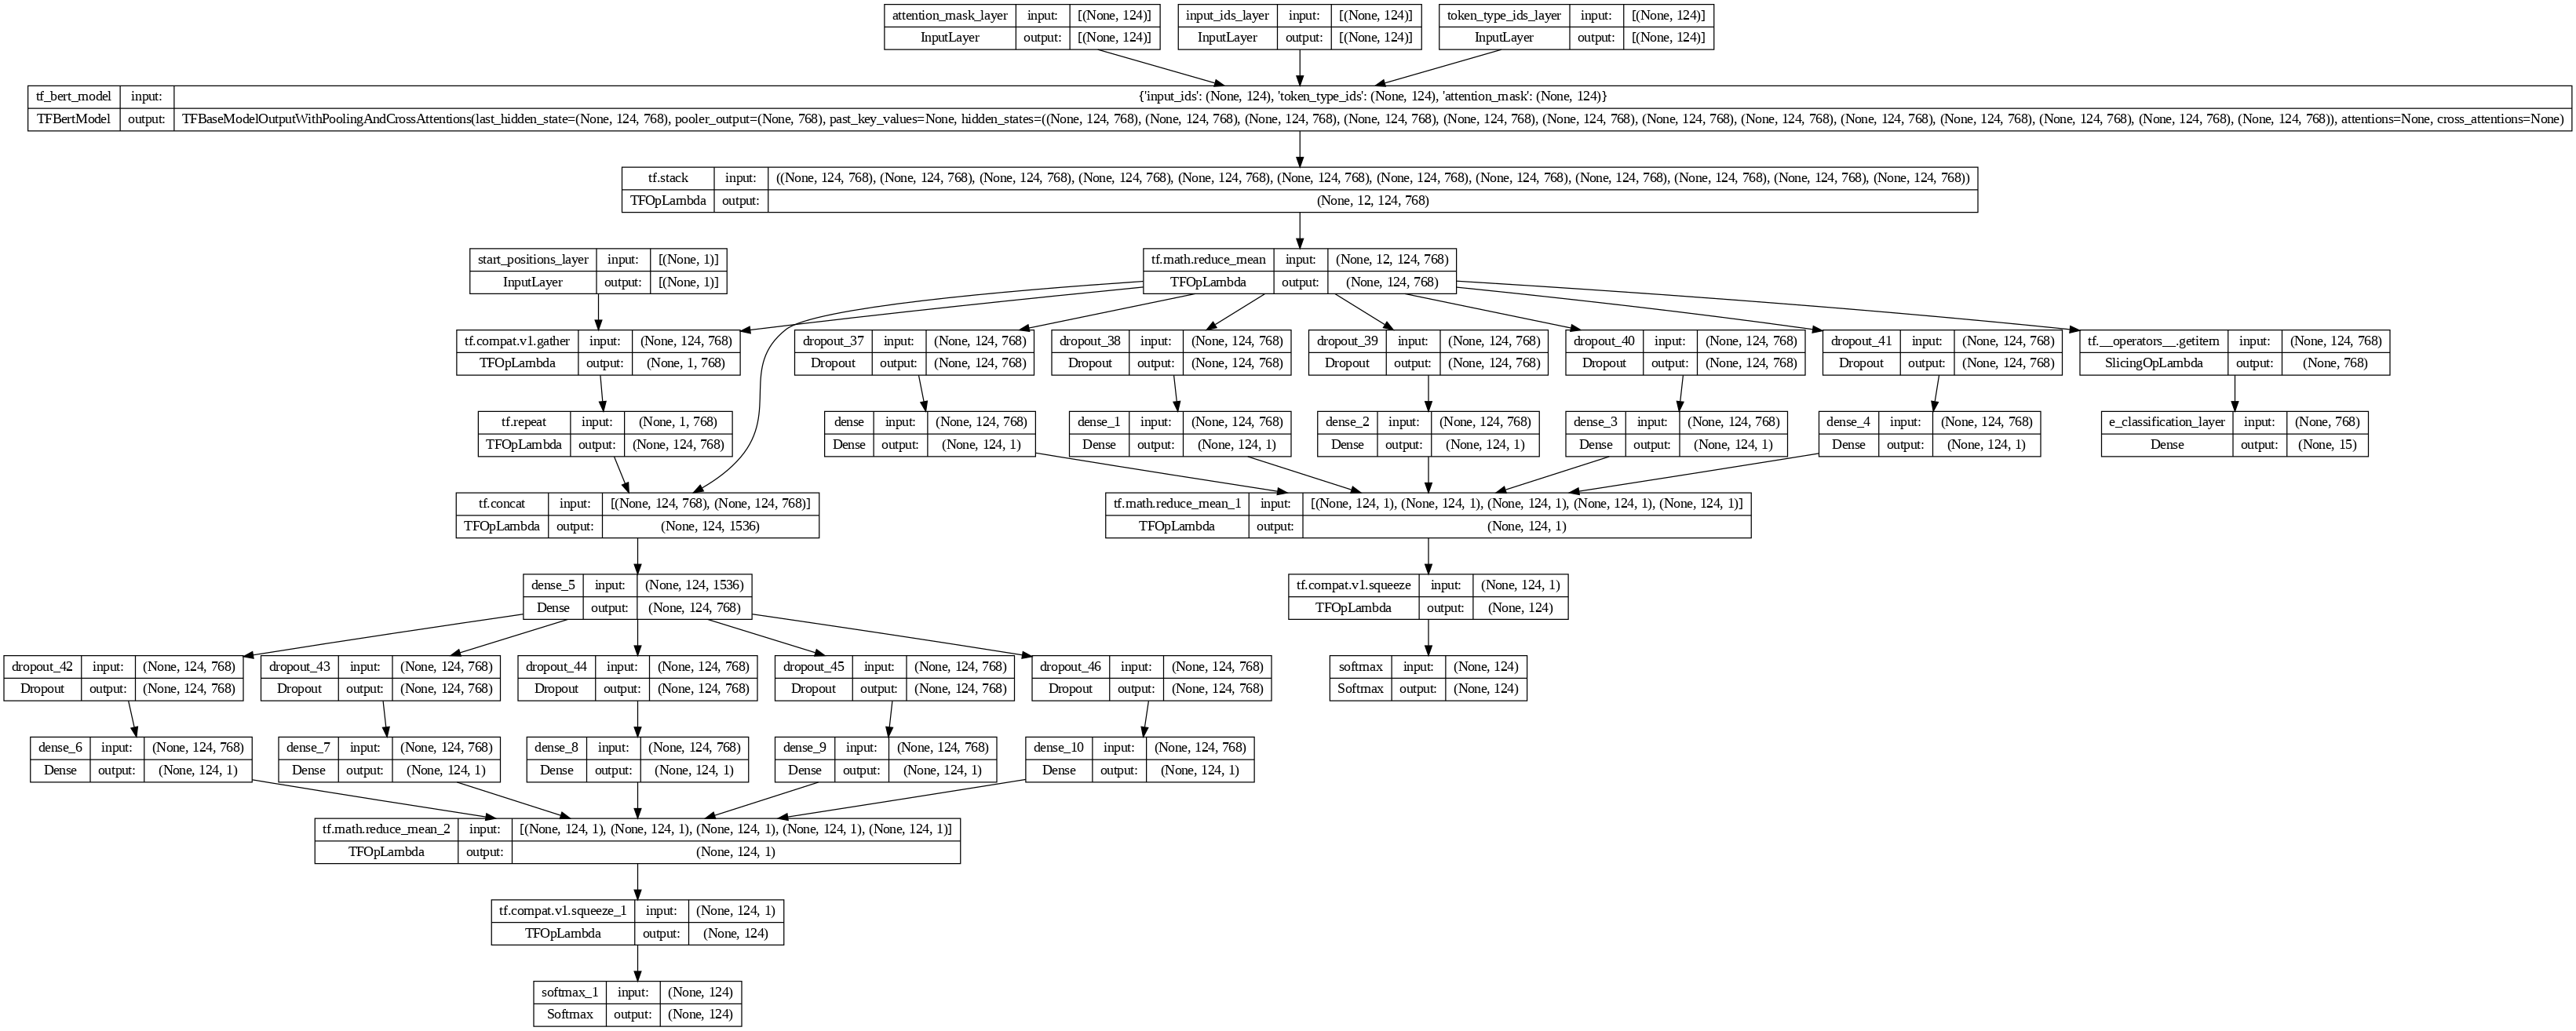

In [ ]:
keras.utils.plot_model(ece_model, show_shapes=True, dpi=90)

## **Baseline:** Bhat and Modi on Unaugmented GNE

In [ ]:
process_baseline = process_train_data(gne_train_preprocessed)

ec_train_texts = process_baseline[0]
ec_train_e_labels = process_baseline[1]
ec_train_si_labels = process_baseline[2]
ec_train_ei_labels = process_baseline[3]
ec_train_encodings = process_baseline[4]

In [ ]:
ece_model = create_ece_model()

In [ ]:
ece_model_history = ece_model.fit([ec_train_encodings.input_ids, ec_train_encodings.token_type_ids, ec_train_encodings.attention_mask, ec_train_si_labels],
                                  [ec_train_e_labels, ec_train_si_labels, ec_train_ei_labels],
                                  batch_size=32,
                                  epochs=4,
                                  )

Epoch 1/4


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


96/96 [==============================] - 159s 2s/step - loss: 2.1882 - e_classification_layer_loss: 2.5505 - softmax_2_loss: 2.4711 - softmax_3_loss: 1.1806 - e_classification_layer_accuracy: 0.1699 - softmax_2_accuracy: 0.2445 - softmax_3_accuracy: 0.8102
Epoch 2/4
96/96 [==============================] - 155s 2s/step - loss: 1.8454 - e_classification_layer_loss: 2.5008 - softmax_2_loss: 1.7916 - softmax_3_loss: 0.5886 - e_classification_layer_accuracy: 0.1888 - softmax_2_accuracy: 0.3809 - softmax_3_accuracy: 0.8633
Epoch 3/4
96/96 [==============================] - 153s 2s/step - loss: 1.7236 - e_classification_layer_loss: 2.4650 - softmax_2_loss: 1.4839 - softmax_3_loss: 0.4807 - e_classification_layer_accuracy: 0.1908 - softmax_2_accuracy: 0.4837 - softmax_3_accuracy: 0.8665
Epoch 4/4
96/96 [==============================] - 153s 2s/step - loss: 1.5427 - e_classification_layer_loss: 2.3159 - softmax_2_loss: 1.1401 - softmax_3_loss: 0.3986 - e_classification_layer_accuracy: 0.2354 

In [ ]:
run_valid_evaluation()

24/24 [==============================] - 7s 306ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/o

                                           precision    recall  f1-score   support

                                    anger     0.2370    0.4824    0.3178        85
                                annoyance     0.0000    0.0000    0.0000        58
                                  disgust     0.0000    0.0000    0.0000        65
                                     fear     0.5000    0.0147    0.0286        68
                                    guilt     1.0000    0.0769    0.1429        26
                                      joy     0.0000    0.0000    0.0000        45
                      love_including_like     0.0000    0.0000    0.0000        12
negative_anticipation_including_pessimism     0.0000    0.0000    0.0000        42
                        negative_surprise     0.1767    0.6179    0.2749       123
 positive_anticipation_including_optimism     0.0000    0.0000    0.0000        39
                        positive_surprise     0.3058    0.4405    0.3610        84
   

In [ ]:
run_test_evaluation()

30/30 [==============================] - 9s 291ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/o

                                           precision    recall  f1-score   support

                                    anger     0.1782    0.4500    0.2553        80
                                annoyance     0.0000    0.0000    0.0000        84
                                  disgust     0.0000    0.0000    0.0000        82
                                     fear     0.0000    0.0000    0.0000        81
                                    guilt     0.3333    0.0606    0.1026        33
                                      joy     0.0000    0.0000    0.0000        49
                      love_including_like     0.0000    0.0000    0.0000        15
negative_anticipation_including_pessimism     0.0000    0.0000    0.0000        53
                        negative_surprise     0.2130    0.6845    0.3249       168
 positive_anticipation_including_optimism     0.0000    0.0000    0.0000        71
                        positive_surprise     0.3011    0.4492    0.3605       118
   

### **Brief Sanity Check:** Does Model Output Spans that are Better than Simply Just Taking the Whole Sentence?

In [ ]:
end_of_sit = [np.argmax(i == 0) - 1 for i in ec_valid_encodings.input_ids]
for i in range(len(end_of_sit)):
  if end_of_sit[i] == -1:
    end_of_sit[i] = 123
zeros = list(np.zeros(len(end_of_sit)))
zeros = [int(i) for i in zeros]

In [ ]:
compute_f1_score(zeros, end_of_sit, ec_valid_si_labels, ec_valid_ei_labels)

0.6402911081798954

In [ ]:
end_of_sit = [np.argmax(i == 0) - 1 for i in ec_test_encodings.input_ids]
for i in range(len(end_of_sit)):
  if end_of_sit[i] == -1:
    end_of_sit[i] = 123
zeros = list(np.zeros(len(end_of_sit)))
zeros = [int(i) for i in zeros]

In [ ]:
compute_f1_score(zeros, end_of_sit, ec_test_si_labels, ec_test_ei_labels)

0.6208464876523567

## **Experiment 1:** Bhat and Modi on GNE Augmented to 20,000 via Random Token Swap with Top Cosine Similarity Token, Balancing Classes

In [ ]:
gne_augment2_preprocessed = pd.read_csv(f'{AUGMENT_PATH}/augment_2_gne_r_balanced.csv')

In [ ]:
process_augment_2 = process_train_data(gne_augment2_preprocessed)

In [ ]:
ec_train_texts = process_augment_2[0]
ec_train_e_labels = process_augment_2[1]
ec_train_si_labels = process_augment_2[2]
ec_train_ei_labels = process_augment_2[3]
ec_train_encodings = process_augment_2[4]

In [ ]:
ece_model2 = create_ece_model()

In [ ]:
ece_model_history = ece_model2.fit([ec_train_encodings.input_ids, ec_train_encodings.token_type_ids, ec_train_encodings.attention_mask, ec_train_si_labels],
                                  [ec_train_e_labels, ec_train_si_labels, ec_train_ei_labels],
                                  batch_size=32,
                                  epochs=2,
                                  )

Epoch 1/2


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


626/626 [==============================] - 1002s 2s/step - loss: 1.7439 - e_classification_layer_loss: 2.4632 - softmax_2_loss: 1.4435 - softmax_3_loss: 0.6059 - e_classification_layer_accuracy: 0.1798 - softmax_2_accuracy: 0.5617 - softmax_3_accuracy: 0.8687
Epoch 2/2
626/626 [==============================] - 991s 2s/step - loss: 0.8317 - e_classification_layer_loss: 1.2963 - softmax_2_loss: 0.5073 - softmax_3_loss: 0.2269 - e_classification_layer_accuracy: 0.5899 - softmax_2_accuracy: 0.8587 - softmax_3_accuracy: 0.9462


In [ ]:
run_valid_evaluation(ece_model2)

24/24 [==============================] - 8s 325ms/step
                                           precision    recall  f1-score   support

                                    anger     0.3718    0.3412    0.3558        85
                                annoyance     0.0769    0.0517    0.0619        58
                                  disgust     0.2083    0.1538    0.1770        65
                                     fear     0.3448    0.4412    0.3871        68
                                    guilt     0.1860    0.3077    0.2319        26
                                      joy     0.4167    0.2222    0.2899        45
                      love_including_like     0.0000    0.0000    0.0000        12
negative_anticipation_including_pessimism     0.1525    0.4286    0.2250        42
                        negative_surprise     0.1963    0.1707    0.1826       123
 positive_anticipation_including_optimism     0.1795    0.3590    0.2393        39
                        positiv

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/o

24/24 [==============================] - 7s 299ms/step
f1_score: 0.7515245437156506


In [ ]:
run_test_evaluation(ece_model2)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


30/30 [==============================] - 18s 594ms/step
                                           precision    recall  f1-score   support

                                    anger     0.3125    0.2500    0.2778        80
                                annoyance     0.0882    0.0714    0.0789        84
                                  disgust     0.2500    0.1951    0.2192        82
                                     fear     0.3578    0.4815    0.4105        81
                                    guilt     0.2623    0.4848    0.3404        33
                                      joy     0.2759    0.1633    0.2051        49
                      love_including_like     0.0000    0.0000    0.0000        15
negative_anticipation_including_pessimism     0.1554    0.4340    0.2289        53
                        negative_surprise     0.2295    0.1667    0.1931       168
 positive_anticipation_including_optimism     0.2712    0.4507    0.3386        71
                        positi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/o

30/30 [==============================] - 10s 323ms/step
f1_score: 0.7571183031577967


In [ ]:
# Save the weights
checkpoint_dir = '/content/drive/MyDrive/w266_final_project/model_checkpoints'
ece_model2.save_weights(f'{checkpoint_dir}/ece_model2')

In [ ]:
# Create a new model instance
ece_model2 = create_ece_model()

# Restore the weights
ece_model2.load_weights(f'{checkpoint_dir}/ece_model2')

## **Experiment 2:** Bhat and Modi on GNE Augmented to 20,000 via Random Token Swap with Insertion and Deletion, Balancing Classes

In [ ]:
gne_augment3_preprocessed = pd.read_csv(f'{AUGMENT_PATH}/augment_3_gne_r_bal_delins.csv')

In [ ]:
process_augment_3 = process_train_data(gne_augment3_preprocessed)

In [ ]:
ec_train_texts = process_augment_3[0]
ec_train_e_labels = process_augment_3[1]
ec_train_si_labels = process_augment_3[2]
ec_train_ei_labels = process_augment_3[3]
ec_train_encodings = process_augment_3[4]

In [ ]:
ece_model3 = create_ece_model()

In [ ]:
ece_model_history = ece_model3.fit([ec_train_encodings.input_ids, ec_train_encodings.token_type_ids, ec_train_encodings.attention_mask, ec_train_si_labels],
                                  [ec_train_e_labels, ec_train_si_labels, ec_train_ei_labels],
                                  batch_size=32,
                                  epochs=2,
                                  )

Epoch 1/2


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


626/626 [==============================] - 1012s 2s/step - loss: 2.4115 - e_classification_layer_loss: 2.6843 - softmax_loss: 2.1818 - softmax_1_loss: 2.0957 - e_classification_layer_accuracy: 0.0983 - softmax_accuracy: 0.3142 - softmax_1_accuracy: 0.3158
Epoch 2/2
626/626 [==============================] - 1005s 2s/step - loss: 1.8157 - e_classification_layer_loss: 2.0531 - softmax_loss: 1.5127 - softmax_1_loss: 1.6440 - e_classification_layer_accuracy: 0.3540 - softmax_accuracy: 0.5283 - softmax_1_accuracy: 0.3943


In [ ]:
run_valid_evaluation()

24/24 [==============================] - 8s 331ms/step
                                           precision    recall  f1-score   support

                                    anger     0.4079    0.3647    0.3851        85
                                annoyance     0.5000    0.0172    0.0333        58
                                  disgust     0.2857    0.0308    0.0556        65
                                     fear     0.3033    0.5441    0.3895        68
                                    guilt     0.3684    0.2692    0.3111        26
                                      joy     0.3415    0.3111    0.3256        45
                      love_including_like     0.5000    0.1667    0.2500        12
negative_anticipation_including_pessimism     0.5000    0.0476    0.0870        42
                        negative_surprise     0.2559    0.4390    0.3234       123
 positive_anticipation_including_optimism     0.2500    0.0256    0.0465        39
                        positiv

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/o

24/24 [==============================] - 8s 329ms/step
f1_score: 0.7559500823601746


In [ ]:
run_test_evaluation()

30/30 [==============================] - 9s 310ms/step
                                           precision    recall  f1-score   support

                                    anger     0.2542    0.1875    0.2158        80
                                annoyance     0.6667    0.0238    0.0460        84
                                  disgust     0.5000    0.0610    0.1087        82
                                     fear     0.3116    0.5309    0.3927        81
                                    guilt     0.2424    0.2424    0.2424        33
                                      joy     0.2400    0.3673    0.2903        49
                      love_including_like     0.3333    0.0667    0.1111        15
negative_anticipation_including_pessimism     0.4286    0.0566    0.1000        53
                        negative_surprise     0.2695    0.4524    0.3378       168
 positive_anticipation_including_optimism     0.1111    0.0282    0.0449        71
                        positiv

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


30/30 [==============================] - 10s 331ms/step
f1_score: 0.7552733020756796


In [ ]:
# Save the weights
ece_model3.save_weights('./checkpoints/ece_model3')

In [ ]:
# Create a new model instance
#ece_model3 = create_ece_model()

# Restore the weights
#ece_model3.load_weights('./checkpoints/ece_model3')

## **Experiment 3:** Bhat and Modi on GNE Augmented to 20,000 via Previous Methods Plus Appending EmoCause, Balancing Classes

In [ ]:
gne_augment4_preprocessed = pd.read_csv(f'{AUGMENT_PATH}/augment_4_gne_w_emocause.csv')

In [ ]:
process_augment_4 = process_train_data(gne_augment4_preprocessed)

In [ ]:
ec_train_texts = process_augment_4[0]
ec_train_e_labels = process_augment_4[1]
ec_train_si_labels = process_augment_4[2]
ec_train_ei_labels = process_augment_4[3]
ec_train_encodings = process_augment_4[4]

In [ ]:
ece_model4 = create_ece_model()

In [ ]:
ece_model_history = ece_model4.fit([ec_train_encodings.input_ids, ec_train_encodings.token_type_ids, ec_train_encodings.attention_mask, ec_train_si_labels],
                                  [ec_train_e_labels, ec_train_si_labels, ec_train_ei_labels],
                                  batch_size=32,
                                  epochs=2,
                                  )

Epoch 1/2


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


626/626 [==============================] - 1021s 2s/step - loss: 1.9231 - e_classification_layer_loss: 1.9069 - softmax_2_loss: 1.7980 - softmax_3_loss: 2.0808 - e_classification_layer_accuracy: 0.4018 - softmax_2_accuracy: 0.4690 - softmax_3_accuracy: 0.3638
Epoch 2/2
626/626 [==============================] - 1025s 2s/step - loss: 1.3352 - e_classification_layer_loss: 1.1961 - softmax_2_loss: 1.2775 - softmax_3_loss: 1.6713 - e_classification_layer_accuracy: 0.6332 - softmax_2_accuracy: 0.6003 - softmax_3_accuracy: 0.4455


In [ ]:
run_valid_evaluation()

24/24 [==============================] - 8s 329ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/o

                                           precision    recall  f1-score   support

                                    anger     0.2955    0.1529    0.2016        85
                                annoyance     0.0000    0.0000    0.0000        58
                                  disgust     0.3143    0.1692    0.2200        65
                                     fear     1.0000    0.0147    0.0290        68
                                    guilt     0.1531    0.5769    0.2419        26
                                      joy     0.2857    0.2222    0.2500        45
                      love_including_like     0.0000    0.0000    0.0000        12
negative_anticipation_including_pessimism     0.0588    0.0714    0.0645        42
                        negative_surprise     0.2308    0.1951    0.2115       123
 positive_anticipation_including_optimism     0.1304    0.1538    0.1412        39
                        positive_surprise     0.2073    0.6786    0.3175        84
   

In [ ]:
run_test_evaluation()

30/30 [==============================] - 10s 335ms/step
                                           precision    recall  f1-score   support

                                    anger     0.2059    0.0875    0.1228        80
                                annoyance     0.0000    0.0000    0.0000        84
                                  disgust     0.3333    0.1829    0.2362        82
                                     fear     0.2000    0.0247    0.0440        81
                                    guilt     0.1681    0.5758    0.2603        33
                                      joy     0.2903    0.3673    0.3243        49
                      love_including_like     0.0000    0.0000    0.0000        15
negative_anticipation_including_pessimism     0.1786    0.1887    0.1835        53
                        negative_surprise     0.2917    0.2500    0.2692       168
 positive_anticipation_including_optimism     0.2529    0.3099    0.2785        71
                        positi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/o

30/30 [==============================] - 10s 337ms/step
f1_score: 0.7166933753422952


In [ ]:
# Save the weights
ece_model4.save_weights('./checkpoints/ece_model4')

In [ ]:
# Create a new model instance
#ece_model4 = create_ece_model()

# Restore the weights
#ece_model4.load_weights('./checkpoints/ece_model4')

## **Post-Analysis:** Looking at Spans and Confusions of Experiment 2 Run

In [ ]:
model_2_test_run = run_samp_evaluation(ece_model2, ec_test_encodings, ec_test_si_labels, ec_test_ei_labels)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


30/30 [==============================] - 10s 319ms/step


### **Confusion Matrix:** Any Insights that can Explain Why we Didn't Get the Results we Hoped For?

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint

In [ ]:
# Store predicted test labels from last run of ece_model2 for future use.
model_2_test_run[0]

<tf.Tensor: shape=(960,), dtype=int64, numpy=
array([ 4, 10,  2,  0,  7, 14, 10,  0, 10,  9,  9, 10,  8,  9,  3,  0,  5,
       10,  8, 10, 10,  9, 10, 10,  8,  7,  7,  8,  1,  8,  2, 10, 12,  2,
        7,  7,  0,  8,  1,  7,  5,  3,  8,  7,  7,  7,  7,  5, 10,  0, 12,
        7,  9,  8,  1, 10,  8,  0,  3,  2,  9,  1,  8,  9,  7,  2, 13,  3,
        7,  3, 11,  1, 10,  7,  3, 10,  2, 12,  1,  7,  7,  8,  8,  1,  9,
        9,  3,  2,  3,  2,  0,  9,  7, 10, 10,  3,  9,  2,  8,  7,  7,  7,
        0,  4,  3,  2,  7,  8,  5,  9,  1,  9,  4,  8,  9,  3,  3,  0,  9,
        7,  9,  2,  8, 12,  9,  8,  2, 10,  7,  3,  7,  5,  2,  8,  3, 10,
        7,  0,  2,  3, 12, 10,  5,  2,  7,  3,  1,  7,  7,  9,  7,  2,  9,
        8,  4,  8,  1, 12,  2,  3,  2,  7,  3,  7,  8,  9, 14,  4,  3,  2,
       12,  7,  3,  0,  3,  1,  4,  2,  2,  7,  4,  9,  0,  1,  8,  4,  8,
       10,  9,  8,  1,  2,  2,  1,  4,  9,  3,  5,  4,  8,  9,  5,  8,  8,
        4,  4,  8,  9,  9,  8,  0,  0,  7,  7, 10,  1,

In [ ]:
[(i, target_names[i]) for i in range(len(target_names))]

[(0, 'anger'),
 (1, 'annoyance'),
 (2, 'disgust'),
 (3, 'fear'),
 (4, 'guilt'),
 (5, 'joy'),
 (6, 'love_including_like'),
 (7, 'negative_anticipation_including_pessimism'),
 (8, 'negative_surprise'),
 (9, 'positive_anticipation_including_optimism'),
 (10, 'positive_surprise'),
 (11, 'pride'),
 (12, 'sadness'),
 (13, 'shame'),
 (14, 'trust')]

In [ ]:
# Reorder confusion matrix by similar categories
order = np.array([1, 13, 4, 12, 0, 2, 3, 7, 8, 10, 9, 5, 11, 6, 14])
ordered_names = ['annoyance', 'shame', 'guilt', 'sadness', 'anger', 'disgust', 'fear', 'negative_anticipation',
                 'negative_surprise', 'positive_surprise', 'positive_anticipation', 'joy', 'pride', 'love_including_like', 'trust']

In [ ]:
cm = pd.crosstab(ec_test_e_labels, model_2_test_run[0],
                 rownames=['Actual'], colnames=['Predicted'])

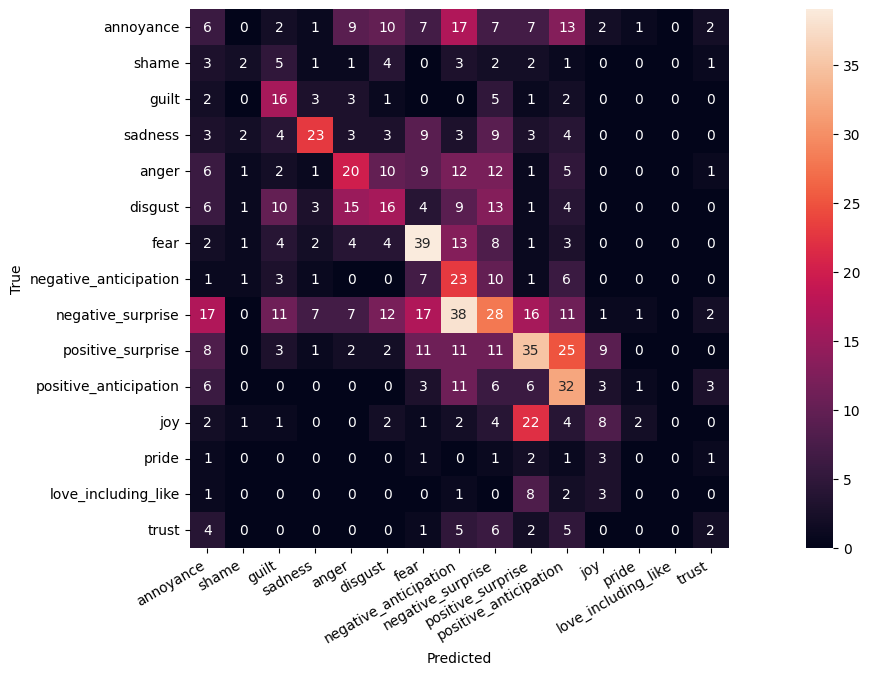

In [ ]:
plt.figure(figsize=(20,7))
sns.heatmap(
    cm.iloc[order, order], annot=True,
    xticklabels=ordered_names,
    yticklabels=ordered_names)
plt.xlabel("Predicted")
plt.xticks(rotation=30, ha='right')
plt.ylabel("True")
plt.gca().set_aspect('equal')

In [ ]:
# Redoing confusion matrix in scikit learn to double check I did the ordering right
cm_sk = tf.math.confusion_matrix(ec_test_e_labels, model_2_test_run[0])

Text(220.5815972222222, 0.5, 'True')

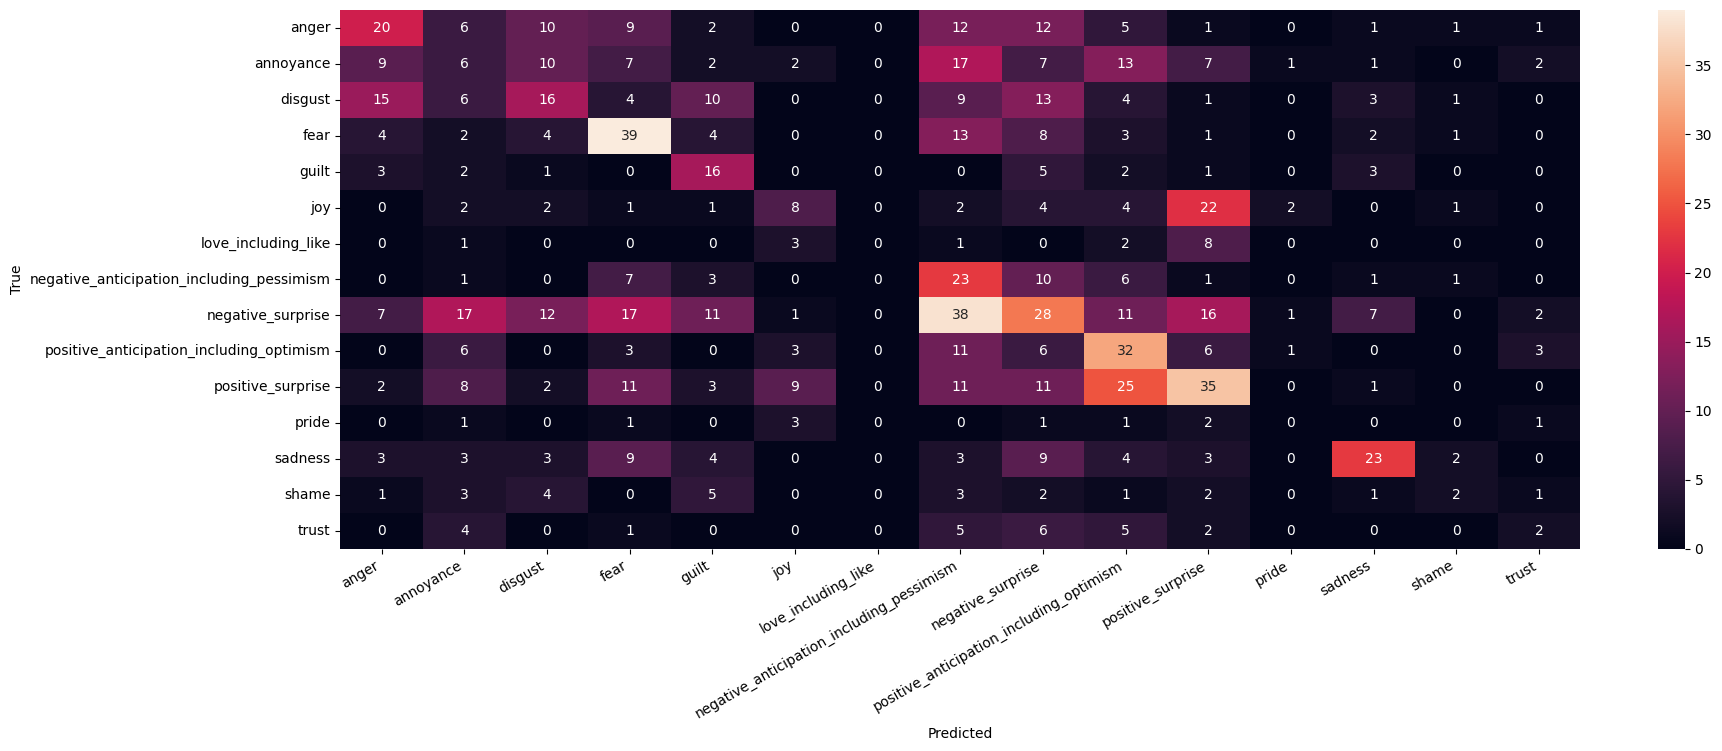

In [ ]:
plt.figure(figsize=(20,7))
sns.heatmap(
    cm_sk, annot=True,
    xticklabels=target_names,
    yticklabels=target_names)
plt.xlabel("Predicted")
plt.xticks(rotation=30, ha='right')
plt.ylabel("True")

### **Output Some Predictions:** Are The Wrong Ones Reasonable?

In [ ]:
# True Label is Disgust
disgust_true_indices = np.where(ec_test_e_labels == 2)

In [ ]:
# Predicted Label is Anger
anger_pred_indices = np.where(model_2_test_run[0] == 0)

In [ ]:
# Intersection
np.intersect1d(disgust_true_indices, anger_pred_indices)

array([ 36,  57, 210, 211, 259, 507, 545, 788, 809, 826, 851, 888, 898,
       911, 952])

In [ ]:
gne_test_preprocessed.iloc[np.intersect1d(disgust_true_indices, anger_pred_indices)]

,Unnamed: 0,headline,dominant_emotion,cause,cause_span,start_index,end_index,emotion_label
36,1317,"trump explains 'nasty' meghan markle comment, ...",disgust,"[[""explains 'nasty' meghan markle comment, but...","explains 'nasty' meghan markle comment, but ba...",3,20,2
57,619,trump taunts democrats with his immigration plan,disgust,"[[""taunts democrats with his immigration plan""]]",taunts democrats with his immigration plan,3,10,2
210,786,morning joe tosses softballs to dem demanding ...,disgust,"[[""tosses softballs to dem demanding devos res...",tosses softballs to dem demanding devos resign,4,13,2
211,2451,'handmaid's tale' actress slams 'disgusting' a...,disgust,"[[""slams 'disgusting' abortion bans"",""abortion...",slams 'disgusting' abortion bans,10,17,2
259,896,world cup fans chant 'f**k trump' during fox n...,disgust,"[[""during fox news live shot""]]",during fox news live shot,13,17,2
507,913,afl-cio president opposes green new deal,disgust,"[[""green new deal""]]",green new deal,10,12,2
545,4195,‘evil has no limit’: blue-checked uk journo’s ...,disgust,"[[""blue-checked uk journo’s case for more abor...",blue-checked uk journo’s case for more abortio...,8,26,2
788,3631,trump suggests 'loose and stupid' iranian offi...,disgust,"[[""iranian officer attacked us drone"",""attacke...",iranian officer attacked us drone,9,15,2
809,4959,donald trump jr joined an army of dubious soci...,disgust,"[[""joined an army of dubious social media trol...",joined an army of dubious social media trolls ...,7,29,2
826,832,stephen miller's uncle: trump's anti-immigrant...,disgust,"[[""trump's anti-immigrant comments demonize as...",trump's anti-immigrant comments demonize asylu...,9,25,2


### **Look at Spans:** Are They Reasonable?

In [ ]:
# Get span prediction of i-th test example, checking to see whether spans are reasonable.
def get_span_prediction(i):
  return spanbert_tokenizer.convert_ids_to_tokens(spanbert_tokenizer(gne_test_preprocessed.headline[i]).input_ids[model_2_test_run[1][i]:model_2_test_run[2][i]+1])

In [ ]:
for i in range(10):
  print(get_span_prediction(i))

['for', 'awful', "'", 've', '##gg', '##ie', 'b', '##urger', "'", 'ban']
['the', 'mail', "'", 's', 'dem', '##ent', '##ia', 'care', 'campaign']
['i', 'was', 'right', 'to', 'critic', '##ize', 'fed', "'", 's', 'rate', 'hike', '##s']
['protest', 'detention', 'centers']
['isn', '’', 't', 'going', 'to', 'stop', 'climate', 'change']
['let', '’', 's', 'imp', '##each', 't', '##rump', 'rather', 'than', 'run', 'against', 'him']
['who', 'fell', 'and', 'walk', 'him', 'home', 'to', 'clean', 'his', 'wounds']
['e', '##cu', '##ador', 'spread', 'lies', 'about', 'w', '##iki', '##lea', '##ks', 'founder']
['builds', '42', 'miles', 'of', 'mostly', 'replacement', 'border', 'wall', 'since', 't', '##rump', "'", 's', 'inauguration']
['there', '’', 's', 'a', 'classic', 'pattern', 'to', 'f', '##ascism', 'and', 'we', '’', 're', 'seeing', 'some', 'of', 'it', 'play', 'out', 'right', 'now']


In [ ]:
gne_test_preprocessed.head(10)

,Unnamed: 0,headline,dominant_emotion,cause,cause_span,start_index,end_index,emotion_label
0,475,mississippi sued for awful 'veggie burger' ban,sadness,"[[""'veggie burger' ban""]]",'veggie burger' ban,8,15,12
1,2907,judi dench leads celebrity support for the mai...,joy,"[[""celebrity support""]]",celebrity support,6,7,5
2,3920,economist moore: i was right to criticize fed'...,disgust,"[[""criticize""]]",criticize,10,11,2
3,735,hundreds of jewish activists surround ice offi...,anger,"[[""surround ice office to protest detention ce...",surround ice office to protest detention centers,7,13,0
4,493,planting ‘billions of trees’ isn’t going to st...,negative_anticipation_including_pessimism,"[[""isn’t going to stop climate change""]]",isn’t going to stop climate change,8,15,7
5,727,harris joins warren: let’s impeach trump rathe...,annoyance,"[[""let’s impeach trump rather than run against...",let’s impeach trump rather than run against him,8,19,1
6,380,teens assist elderly man who fell and walk him...,negative_surprise,"[[""him home to clean his wounds""],[""man who""]]",him home to clean his wounds,9,14,8
7,2300,lawyer alleges ecuador spread lies about wikil...,guilt,"[[""spread lies about wikileaks founder""]]",spread lies about wikileaks founder,8,15,4
8,699,dhs builds 42 miles of mostly replacement bord...,negative_anticipation_including_pessimism,"[[""replacement border wall since trump's inaug...",replacement border wall since trump's inaugura...,8,16,7
9,4330,hillary: there’s a classic pattern to fascism ...,disgust,"[[""fascism and we’re seeing some of it play ou...",fascism and we’re seeing some of it play out r...,11,24,2
